# Graph-based event fingerprints — Results notebook (Forbush decreases)

This notebook reproduces the **results screening** across your 6 result files (each containing multiple preprocessing configurations) and identifies:

- The **best pipeline for intensity classification** (G3/G4/G5) using **LDA** with **leave-one-event-out (LOEO)** validation  
- The **best pipeline for drop regression** using **PLS regression** with **LOEO** validation  
- Two key figures ready to drop into the manuscript:
  - LDA 2D projection for the best classification pipeline
  - Predicted vs observed drop for the best regression pipeline

> **Data expected in** `/mnt/data/` (already uploaded in this workspace):  
> - `dataset_all.original_imput-True_threshold-True.csv`  
> - `dataset_all.original_imput-False_threshold-False.csv`  
> - `dataset_all_imput-True_threshold-True.csv`  
> - `dataset_all_imput-False_threshold-False.csv`  
> - `dataset_all.imp_imput-True_threshold-True.csv`  
> - `dataset_all.imp_imput-False_threshold-False.csv`


In [ ]:
# File uploaded by David Sierra

# === Setup ===
import math
import warnings
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cross_decomposition import PLSRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    accuracy_score,
    balanced_accuracy_score,
    confusion_matrix,
    f1_score,
    mean_absolute_error,
    mean_squared_error,
    r2_score,
)
from sklearn.model_selection import LeaveOneOut
from sklearn.preprocessing import StandardScaler

warnings.filterwarnings("ignore")
plt.style.use(["science", "ieee"])

DATA_DIR = Path("./")

FILES = [
    "dataset_all.original_imput-True_threshold-True.csv",
    "dataset_all.original_imput-False_threshold-False.csv",
    "dataset_all_imput-True_threshold-True.csv",
    "dataset_all_imput-False_threshold-False.csv",
    "dataset_all.imp_imput-True_threshold-True.csv",
    "dataset_all.imp_imput-False_threshold-False.csv",
]

# Core graph-fingerprint columns (features)
GRAPH_COLS = [
    "global_efficiency",
    "estrada_index",
    "entropy",
    "fractal",
    "hurst_rs",
    "modularity",
    "assortativity",
    "avg_katz",
    "avg_closeness",
    "avg_betweenness",
    "avg_laplacian",
]

# Configuration columns (pipeline factors)
CFG_COLS = ["transformation", "normalization", "adjacency_method"]

print("Found files:")
for f in FILES:
    p = DATA_DIR / f
    print(" -", f, "| exists:", p.exists())

Found files:
 - dataset_all.original_imput-True_threshold-True.csv | exists: True
 - dataset_all.original_imput-False_threshold-False.csv | exists: True
 - dataset_all_imput-True_threshold-True.csv | exists: True
 - dataset_all_imput-False_threshold-False.csv | exists: True
 - dataset_all.imp_imput-True_threshold-True.csv | exists: True
 - dataset_all.imp_imput-False_threshold-False.csv | exists: True


## 1) Load datasets and sanity checks

We check:
- number of rows, unique events
- class counts for `intensity` (important: G2 is often rare)
- verify the expected 30 variants per event: 3 transformations × 5 normalizations × 2 adjacency methods


In [2]:
dfs = {}
summ_rows = []

for fname in FILES:
    df = pd.read_csv(DATA_DIR / fname)
    dfs[fname] = df

    n_rows = len(df)
    n_events = df["event_date"].nunique() if "event_date" in df.columns else np.nan

    intensity_counts = (
        df["intensity"].value_counts(dropna=False).to_dict()
        if "intensity" in df.columns
        else {}
    )
    trans_n = (
        df["transformation"].nunique() if "transformation" in df.columns else np.nan
    )
    norm_n = df["normalization"].nunique() if "normalization" in df.columns else np.nan
    adj_n = (
        df["adjacency_method"].nunique() if "adjacency_method" in df.columns else np.nan
    )

    rows_per_event = n_rows / n_events if n_events else np.nan

    summ_rows.append(
        {
            "file": fname,
            "rows": n_rows,
            "unique_events": n_events,
            "transformations": trans_n,
            "normalizations": norm_n,
            "adjacency_methods": adj_n,
            "rows_per_event": rows_per_event,
            "intensity_counts": intensity_counts,
        }
    )

summary = pd.DataFrame(summ_rows)
summary

,file,rows,unique_events,transformations,normalizations,adjacency_methods,rows_per_event,intensity_counts
0,dataset_all.original_imput-True_threshold-True...,1020,34,3,5,2,30.0,"{'G4': 390, 'G5': 300, 'G3': 300, 'G2': 30}"
1,dataset_all.original_imput-False_threshold-Fal...,1020,34,3,5,2,30.0,"{'G4': 390, 'G5': 300, 'G3': 300, 'G2': 30}"
2,dataset_all_imput-True_threshold-True.csv,1020,34,3,5,2,30.0,"{'G4': 390, 'G5': 300, 'G3': 300, 'G2': 30}"
3,dataset_all_imput-False_threshold-False.csv,1020,34,3,5,2,30.0,"{'G4': 390, 'G5': 300, 'G3': 300, 'G2': 30}"
4,dataset_all.imp_imput-True_threshold-True.csv,1020,34,3,5,2,30.0,"{'G4': 390, 'G5': 300, 'G3': 300, 'G2': 30}"
5,dataset_all.imp_imput-False_threshold-False.csv,1020,34,3,5,2,30.0,"{'G4': 390, 'G5': 300, 'G3': 300, 'G2': 30}"


### Class distribution snapshot

If `G2` appears only once (or extremely rarely), 4-class classification (G2/G3/G4/G5) becomes unstable.  
We will therefore report **G3/G4/G5** as the main multi-class task, plus an optional **binary** task `>=G4 vs G3`.


In [3]:
# Aggregate intensity counts across files (quick overview)
agg_counts = {}
for fname, df in dfs.items():
    c = df["intensity"].value_counts()
    for k, v in c.items():
        agg_counts[k] = agg_counts.get(k, 0) + int(v)

pd.Series(agg_counts).sort_index()

G2     180
G3    1800
G4    2340
G5    1800
dtype: int64

## 2) LOEO evaluation helpers (leakage-safe)

We perform **Leave-One-Out (one event held out)**.  
For each split, we fit imputer/scaler **only on the training fold**, then evaluate on the held-out event.


In [4]:
def _prep_train_test(X_tr, X_te, impute_strategy="median", scale=True):
    imp = SimpleImputer(strategy=impute_strategy)
    X_tr = imp.fit_transform(X_tr)
    X_te = imp.transform(X_te)

    if scale:
        sc = StandardScaler()
        X_tr = sc.fit_transform(X_tr)
        X_te = sc.transform(X_te)
        return X_tr, X_te, imp, sc

    return X_tr, X_te, imp, None


def eval_lda_loeo(df_sub, y_col="intensity", classes=("G3", "G4", "G5")):
    # Multi-class LDA LOEO
    df_sub = df_sub[df_sub[y_col].isin(classes)].copy()
    X = df_sub[GRAPH_COLS].to_numpy()
    y = df_sub[y_col].to_numpy()

    loo = LeaveOneOut()
    yhat, ytrue = [], []

    for tr, te in loo.split(X):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        X_tr, X_te, _, _ = _prep_train_test(
            X_tr, X_te, impute_strategy="median", scale=True
        )

        clf = LinearDiscriminantAnalysis()
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)

        yhat.append(pred[0])
        ytrue.append(y_te[0])

    yhat = np.array(yhat)
    ytrue = np.array(ytrue)

    acc = accuracy_score(ytrue, yhat)
    bacc = balanced_accuracy_score(ytrue, yhat)
    f1m = f1_score(ytrue, yhat, average="macro")

    cm = confusion_matrix(ytrue, yhat, labels=list(classes))
    cm_df = pd.DataFrame(
        cm, index=[f"true_{c}" for c in classes], columns=[f"pred_{c}" for c in classes]
    )

    return {
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "macro_f1": f1m,
        "n": len(ytrue),
        "cm": cm_df,
    }


def eval_lda_binary_loeo(
    df_sub, pos_classes=("G4", "G5"), neg_class="G3", y_col="intensity"
):
    # Binary LOEO: pos = >=G4, neg = G3
    keep = set(pos_classes) | {neg_class}
    df_sub = df_sub[df_sub[y_col].isin(keep)].copy()

    X = df_sub[GRAPH_COLS].to_numpy()
    y_raw = df_sub[y_col].to_numpy()
    y = np.array([1 if v in pos_classes else 0 for v in y_raw])  # 1=pos, 0=neg

    loo = LeaveOneOut()
    yhat, ytrue = [], []

    for tr, te in loo.split(X):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        X_tr, X_te, _, _ = _prep_train_test(
            X_tr, X_te, impute_strategy="median", scale=True
        )

        clf = LinearDiscriminantAnalysis()
        clf.fit(X_tr, y_tr)
        pred = clf.predict(X_te)

        yhat.append(int(pred[0]))
        ytrue.append(int(y_te[0]))

    yhat = np.array(yhat)
    ytrue = np.array(ytrue)

    acc = accuracy_score(ytrue, yhat)
    bacc = balanced_accuracy_score(ytrue, yhat)
    f1m = f1_score(ytrue, yhat, average="macro")

    cm = confusion_matrix(ytrue, yhat, labels=[0, 1])
    cm_df = pd.DataFrame(
        cm, index=["true_G3(0)", "true_>=G4(1)"], columns=["pred_G3(0)", "pred_>=G4(1)"]
    )

    return {
        "accuracy": acc,
        "balanced_accuracy": bacc,
        "macro_f1": f1m,
        "n": len(ytrue),
        "cm": cm_df,
    }


def eval_pls_loeo(df_sub, y_col="drop", n_components=5):
    # PLS regression LOEO
    df_sub = df_sub.copy()
    X = df_sub[GRAPH_COLS].to_numpy()
    y = df_sub[y_col].to_numpy().astype(float)

    loo = LeaveOneOut()
    yhat, ytrue, yhat_baseline = [], [], []

    for tr, te in loo.split(X):
        X_tr, X_te = X[tr], X[te]
        y_tr, y_te = y[tr], y[te]

        # baseline: mean of training fold
        yhat_baseline.append(float(np.mean(y_tr)))

        X_tr, X_te, _, _ = _prep_train_test(
            X_tr, X_te, impute_strategy="median", scale=True
        )

        model = PLSRegression(n_components=n_components)
        model.fit(X_tr, y_tr)
        pred = model.predict(X_te)

        yhat.append(float(np.ravel(pred)[0]))
        ytrue.append(float(y_te[0]))

    yhat = np.array(yhat)
    ytrue = np.array(ytrue)
    yhat_baseline = np.array(yhat_baseline)

    r2 = r2_score(ytrue, yhat)
    mae = mean_absolute_error(ytrue, yhat)
    rmse = math.sqrt(mean_squared_error(ytrue, yhat))

    r2_b = r2_score(ytrue, yhat_baseline)
    mae_b = mean_absolute_error(ytrue, yhat_baseline)
    rmse_b = math.sqrt(mean_squared_error(ytrue, yhat_baseline))

    return {
        "r2": r2,
        "mae": mae,
        "rmse": rmse,
        "n": len(ytrue),
        "baseline_r2": r2_b,
        "baseline_mae": mae_b,
        "baseline_rmse": rmse_b,
        "ytrue": ytrue,
        "yhat": yhat,
    }

## 3) Grid search over the 30 pipeline variants per file

We sweep:
- `transformation` ∈ {none, log, exponential}
- `normalization`  (5 choices as in your files)
- `adjacency_method` ∈ {manhattan, minkowski}

For each file we record:
- **Best multi-class** (G3/G4/G5) by **Macro-F1** (LDA)
- **Best binary** (`>=G4` vs `G3`) by **Macro-F1** (LDA)
- **Best drop regression** by **R²** (PLS with 5 components)


In [5]:
def iter_variants(df):
    for tr in sorted(df["transformation"].dropna().unique()):
        for nm in sorted(df["normalization"].dropna().unique()):
            for adj in sorted(df["adjacency_method"].dropna().unique()):
                sub = df[
                    (df["transformation"] == tr)
                    & (df["normalization"] == nm)
                    & (df["adjacency_method"] == adj)
                ].copy()
                if len(sub) == 0:
                    continue
                yield tr, nm, adj, sub


results_cls, results_bin, results_reg = [], [], []

for fname, df in dfs.items():
    for tr, nm, adj, sub in iter_variants(df):
        # Multi-class G3/G4/G5
        out = eval_lda_loeo(sub, classes=("G3", "G4", "G5"))
        results_cls.append(
            {
                "file": fname,
                "transformation": tr,
                "normalization": nm,
                "adjacency_method": adj,
                "accuracy": out["accuracy"],
                "balanced_accuracy": out["balanced_accuracy"],
                "macro_f1": out["macro_f1"],
                "n": out["n"],
            }
        )

        # Binary >=G4 vs G3
        outb = eval_lda_binary_loeo(sub)
        results_bin.append(
            {
                "file": fname,
                "transformation": tr,
                "normalization": nm,
                "adjacency_method": adj,
                "accuracy": outb["accuracy"],
                "balanced_accuracy": outb["balanced_accuracy"],
                "macro_f1": outb["macro_f1"],
                "n": outb["n"],
            }
        )

        # Regression (drop)
        outr = eval_pls_loeo(sub, y_col="drop", n_components=5)
        results_reg.append(
            {
                "file": fname,
                "transformation": tr,
                "normalization": nm,
                "adjacency_method": adj,
                "r2": outr["r2"],
                "mae": outr["mae"],
                "rmse": outr["rmse"],
                "n": outr["n"],
                "baseline_r2": outr["baseline_r2"],
                "baseline_mae": outr["baseline_mae"],
                "baseline_rmse": outr["baseline_rmse"],
            }
        )

df_cls = pd.DataFrame(results_cls)
df_bin = pd.DataFrame(results_bin)
df_reg = pd.DataFrame(results_reg)

print("Sweeps complete.")
df_cls.head()

Sweeps complete.


,file,transformation,normalization,adjacency_method,accuracy,balanced_accuracy,macro_f1,n
0,dataset_all.original_imput-True_threshold-True...,exponential,decimal_scaling,manhattan,0.363636,0.346154,0.336861,33
1,dataset_all.original_imput-True_threshold-True...,exponential,decimal_scaling,minkowski,0.212121,0.202564,0.206349,33
2,dataset_all.original_imput-True_threshold-True...,exponential,min_max,manhattan,0.303030,0.302564,0.305115,33
3,dataset_all.original_imput-True_threshold-True...,exponential,min_max,minkowski,0.484848,0.487179,0.477078,33
4,dataset_all.original_imput-True_threshold-True...,exponential,none,manhattan,0.393939,0.379487,0.333333,33


## 4) Best pipelines per file (summary tables)

These tables are what you can paste (or adapt) into the paper.


In [6]:
# Best multiclass (G3/G4/G5) by Macro-F1 per file
best_cls = (
    df_cls.sort_values(["file", "macro_f1"], ascending=[True, False])
    .groupby("file", as_index=False)
    .head(1)
    .sort_values("macro_f1", ascending=False)
)

# Best binary by Macro-F1 per file
best_bin = (
    df_bin.sort_values(["file", "macro_f1"], ascending=[True, False])
    .groupby("file", as_index=False)
    .head(1)
    .sort_values("macro_f1", ascending=False)
)

# Best regression by R2 per file
best_reg = (
    df_reg.sort_values(["file", "r2"], ascending=[True, False])
    .groupby("file", as_index=False)
    .head(1)
    .sort_values("r2", ascending=False)
)

best_cls

,file,transformation,normalization,adjacency_method,accuracy,balanced_accuracy,macro_f1,n
15,dataset_all.original_imput-True_threshold-True...,log,none,minkowski,0.575758,0.571795,0.575375,33
71,dataset_all_imput-True_threshold-True.csv,log,decimal_scaling,minkowski,0.575758,0.556410,0.544913,33
46,dataset_all.original_imput-False_threshold-Fal...,log,robust,manhattan,0.545455,0.553846,0.543478,33
97,dataset_all_imput-False_threshold-False.csv,exponential,robust,minkowski,0.484848,0.471795,0.468254,33
159,dataset_all.imp_imput-False_threshold-False.csv,exponential,z_score,minkowski,0.484848,0.471795,0.461320,33
129,dataset_all.imp_imput-True_threshold-True.csv,exponential,z_score,minkowski,0.484848,0.471795,0.461320,33


In [7]:
best_bin

,file,transformation,normalization,adjacency_method,accuracy,balanced_accuracy,macro_f1,n
11,dataset_all.original_imput-True_threshold-True...,log,decimal_scaling,minkowski,0.787879,0.734783,0.741321,33
171,dataset_all.imp_imput-False_threshold-False.csv,none,decimal_scaling,minkowski,0.727273,0.691304,0.685714,33
141,dataset_all.imp_imput-True_threshold-True.csv,none,decimal_scaling,minkowski,0.727273,0.691304,0.685714,33
47,dataset_all.original_imput-False_threshold-Fal...,log,robust,minkowski,0.666667,0.591304,0.593505,33
71,dataset_all_imput-True_threshold-True.csv,log,decimal_scaling,minkowski,0.696970,0.584783,0.587500,33
107,dataset_all_imput-False_threshold-False.csv,log,robust,minkowski,0.636364,0.569565,0.569565,33


In [8]:
best_reg

,file,transformation,normalization,adjacency_method,r2,mae,rmse,n,baseline_r2,baseline_mae,baseline_rmse
115,dataset_all_imput-False_threshold-False.csv,none,none,minkowski,0.350064,2.407463,3.055867,34,-0.061524,2.686221,3.905386
171,dataset_all.imp_imput-False_threshold-False.csv,none,decimal_scaling,minkowski,0.079396,2.708284,3.636935,34,-0.061524,2.686221,3.905386
141,dataset_all.imp_imput-True_threshold-True.csv,none,decimal_scaling,minkowski,0.079396,2.708284,3.636935,34,-0.061524,2.686221,3.905386
6,dataset_all.original_imput-True_threshold-True...,exponential,robust,manhattan,-0.024967,2.796572,3.837550,34,-0.061524,2.686221,3.905386
55,dataset_all.original_imput-False_threshold-Fal...,none,none,minkowski,-0.045620,2.853373,3.876019,34,-0.061524,2.686221,3.905386
67,dataset_all_imput-True_threshold-True.csv,exponential,robust,minkowski,-0.046339,2.695696,3.877353,34,-0.061524,2.686221,3.905386


## 5) Reproduce the manuscript-ready results (recommended pipelines)

### 5.1 Intensity classification (G3/G4/G5)
We select the best-performing pipeline observed in the sweep and compute:
- metrics (LOEO)
- confusion matrix
- a 2D LDA projection figure (for visualization)

### 5.2 Drop regression
We select the best-performing pipeline observed in the sweep and compute:
- metrics (LOEO)
- predicted vs observed plot


In [9]:
# === Pick the best multiclass pipeline overall (highest macro-F1 across all files) ===
best_overall_cls = df_cls.sort_values("macro_f1", ascending=False).iloc[0].to_dict()
best_overall_cls

{'file': 'dataset_all.original_imput-True_threshold-True.csv',
 'transformation': 'log',
 'normalization': 'none',
 'adjacency_method': 'minkowski',
 'accuracy': 0.5757575757575758,
 'balanced_accuracy': 0.5717948717948719,
 'macro_f1': 0.5753748006379585,
 'n': 33}

In [10]:
# Load the chosen subset and compute metrics + confusion matrix
fname = best_overall_cls["file"]
tr = best_overall_cls["transformation"]
nm = best_overall_cls["normalization"]
adj = best_overall_cls["adjacency_method"]

df = dfs[fname]
sub = df[
    (df.transformation == tr) & (df.normalization == nm) & (df.adjacency_method == adj)
].copy()

out = eval_lda_loeo(sub, classes=("G3", "G4", "G5"))
print({k: out[k] for k in ["accuracy", "balanced_accuracy", "macro_f1", "n"]})
out["cm"]

{'accuracy': 0.5757575757575758, 'balanced_accuracy': np.float64(0.5717948717948719), 'macro_f1': 0.5753748006379585, 'n': 33}


,pred_G3,pred_G4,pred_G5
true_G3,6,1,3
true_G4,1,8,4
true_G5,2,3,5


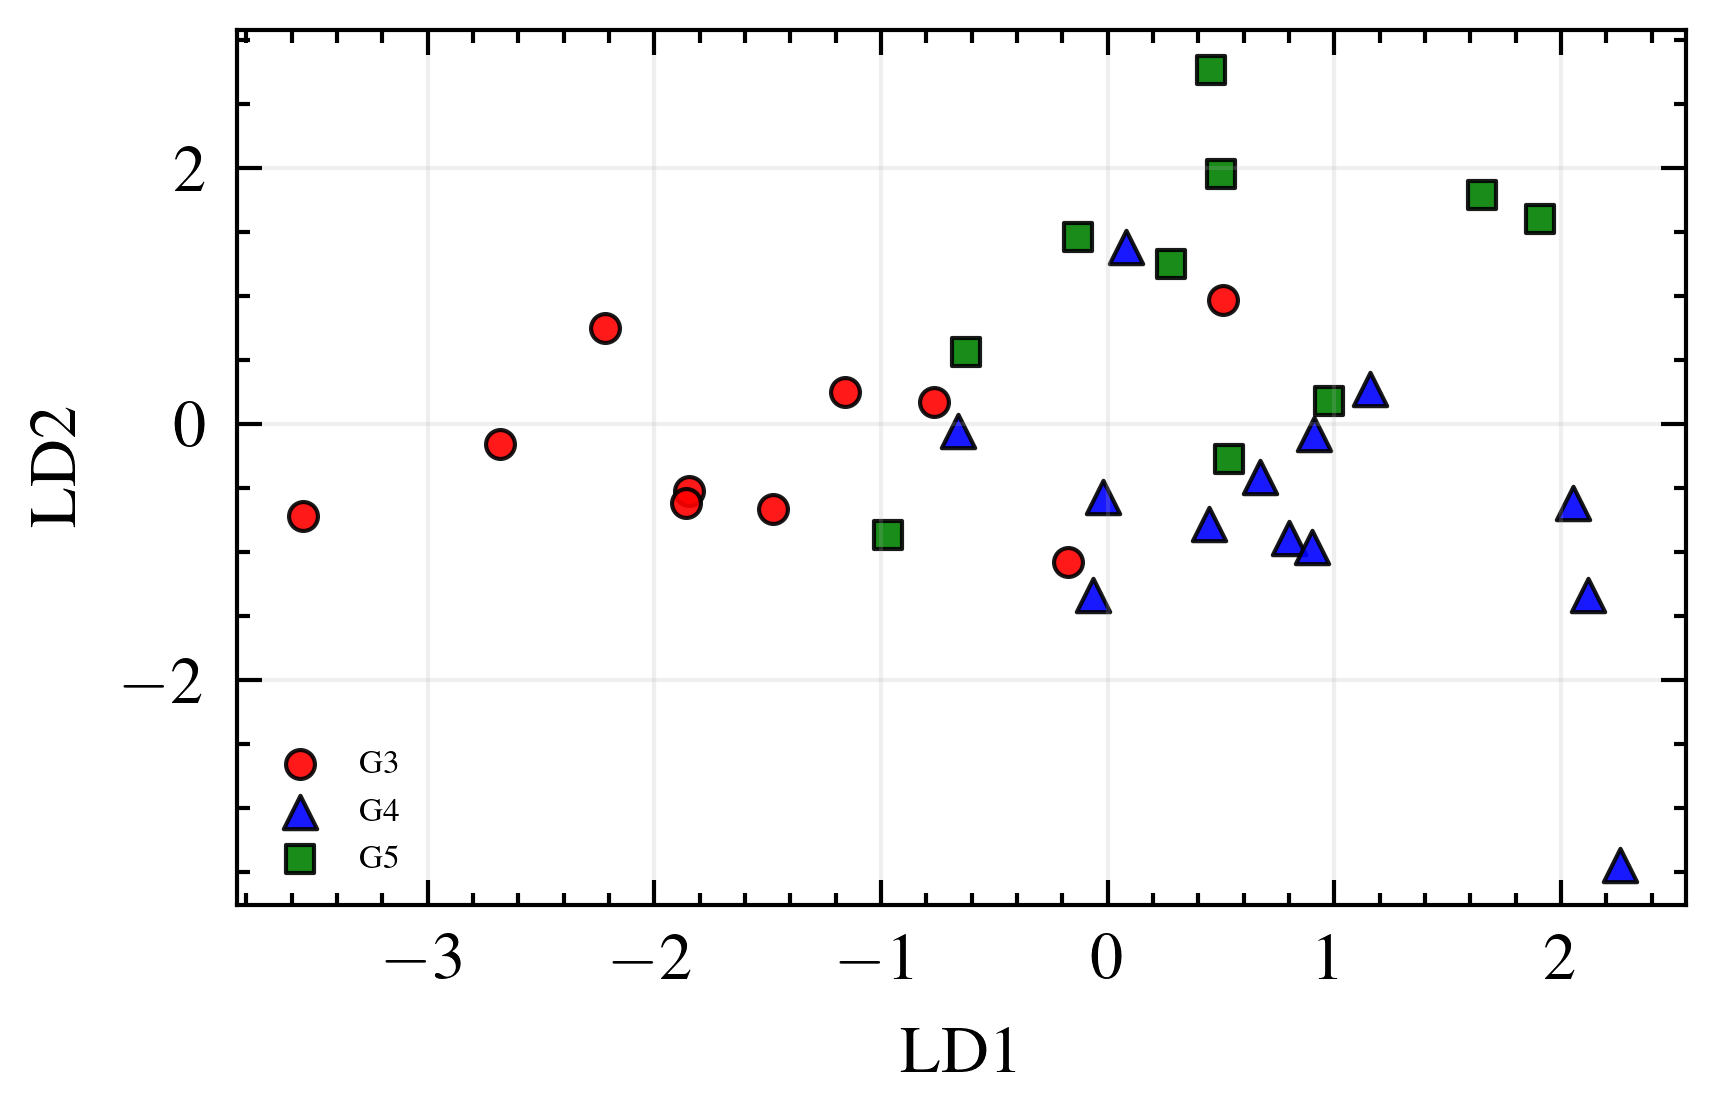

Saved: fig_LDA_projection_G3G4G5.png


In [11]:
# LDA 2D projection (for visualization; uses global scaling on the full subset)
# Note: this is for a clean figure. The performance metrics above remain LOEO.
sub_vis = sub[sub["intensity"].isin(["G3", "G4", "G5"])].copy()
X = sub_vis[GRAPH_COLS].to_numpy()
y = sub_vis["intensity"].to_numpy()

imp = SimpleImputer(strategy="median")
X_imp = imp.fit_transform(X)
sc = StandardScaler()
X_sc = sc.fit_transform(X_imp)

lda = LinearDiscriminantAnalysis()
Z = lda.fit_transform(X_sc, y)

colors = ["r", "b", "g"]
markers = ["o", "^", "s"]
sizes = [12, 16, 12]

plt.figure(figsize=(3, 2))
for i, cls in enumerate(np.unique(y)):
    m = y == cls
    plt.scatter(
        Z[m, 0],
        Z[m, 1],
        label=cls,
        s=sizes[i],
        color=colors[i],
        marker=markers[i],
        edgecolor="k",
        linewidths=0.5,
        alpha=0.9,
    )
plt.grid(alpha=0.2)

plt.xlabel("LD1")
plt.ylabel("LD2")
# plt.title(f"LDA projection (best pipeline)\n{fname} | tr={tr}, norm={nm}, adj={adj}")
plt.legend(ncol=1, fontsize=4, loc=3)
plt.tight_layout()

fig1_path = DATA_DIR / "fig_LDA_projection_G3G4G5.png"
plt.savefig(fig1_path, dpi=220)
plt.show()

print("Saved:", fig1_path)

In [12]:
# Optional: binary task >=G4 vs G3, using the same best multiclass pipeline
outb = eval_lda_binary_loeo(sub)
print({k: outb[k] for k in ["accuracy", "balanced_accuracy", "macro_f1", "n"]})
outb["cm"]

{'accuracy': 0.7575757575757576, 'balanced_accuracy': np.float64(0.6847826086956521), 'macro_f1': 0.6944444444444444, 'n': 33}


,pred_G3(0),pred_>=G4(1)
true_G3(0),5,5
true_>=G4(1),3,20


In [13]:
# === Pick the best regression pipeline overall (highest R2 across all files) ===
best_overall_reg = df_reg.sort_values("r2", ascending=False).iloc[0].to_dict()
best_overall_reg

{'file': 'dataset_all_imput-False_threshold-False.csv',
 'transformation': 'none',
 'normalization': 'none',
 'adjacency_method': 'minkowski',
 'r2': 0.3500636749347995,
 'mae': 2.4074629854109824,
 'rmse': 3.055866899382621,
 'n': 34,
 'baseline_r2': -0.06152433425160719,
 'baseline_mae': 2.686221033868093,
 'baseline_rmse': 3.9053863700950924}

In [14]:
# Compute regression metrics + plot predicted vs observed (PLS-5, LOEO)
fname_r = best_overall_reg["file"]
tr_r = best_overall_reg["transformation"]
nm_r = best_overall_reg["normalization"]
adj_r = best_overall_reg["adjacency_method"]

df_r = dfs[fname_r]
sub_r = df_r[
    (df_r.transformation == tr_r)
    & (df_r.normalization == nm_r)
    & (df_r.adjacency_method == adj_r)
].copy()

outr = eval_pls_loeo(sub_r, y_col="drop", n_components=5)
print(
    {
        k: outr[k]
        for k in [
            "r2",
            "mae",
            "rmse",
            "baseline_r2",
            "baseline_mae",
            "baseline_rmse",
            "n",
        ]
    }
)

{'r2': 0.3500636749347995, 'mae': 2.4074629854109824, 'rmse': 3.055866899382621, 'baseline_r2': -0.06152433425160719, 'baseline_mae': 2.686221033868093, 'baseline_rmse': 3.9053863700950924, 'n': 34}


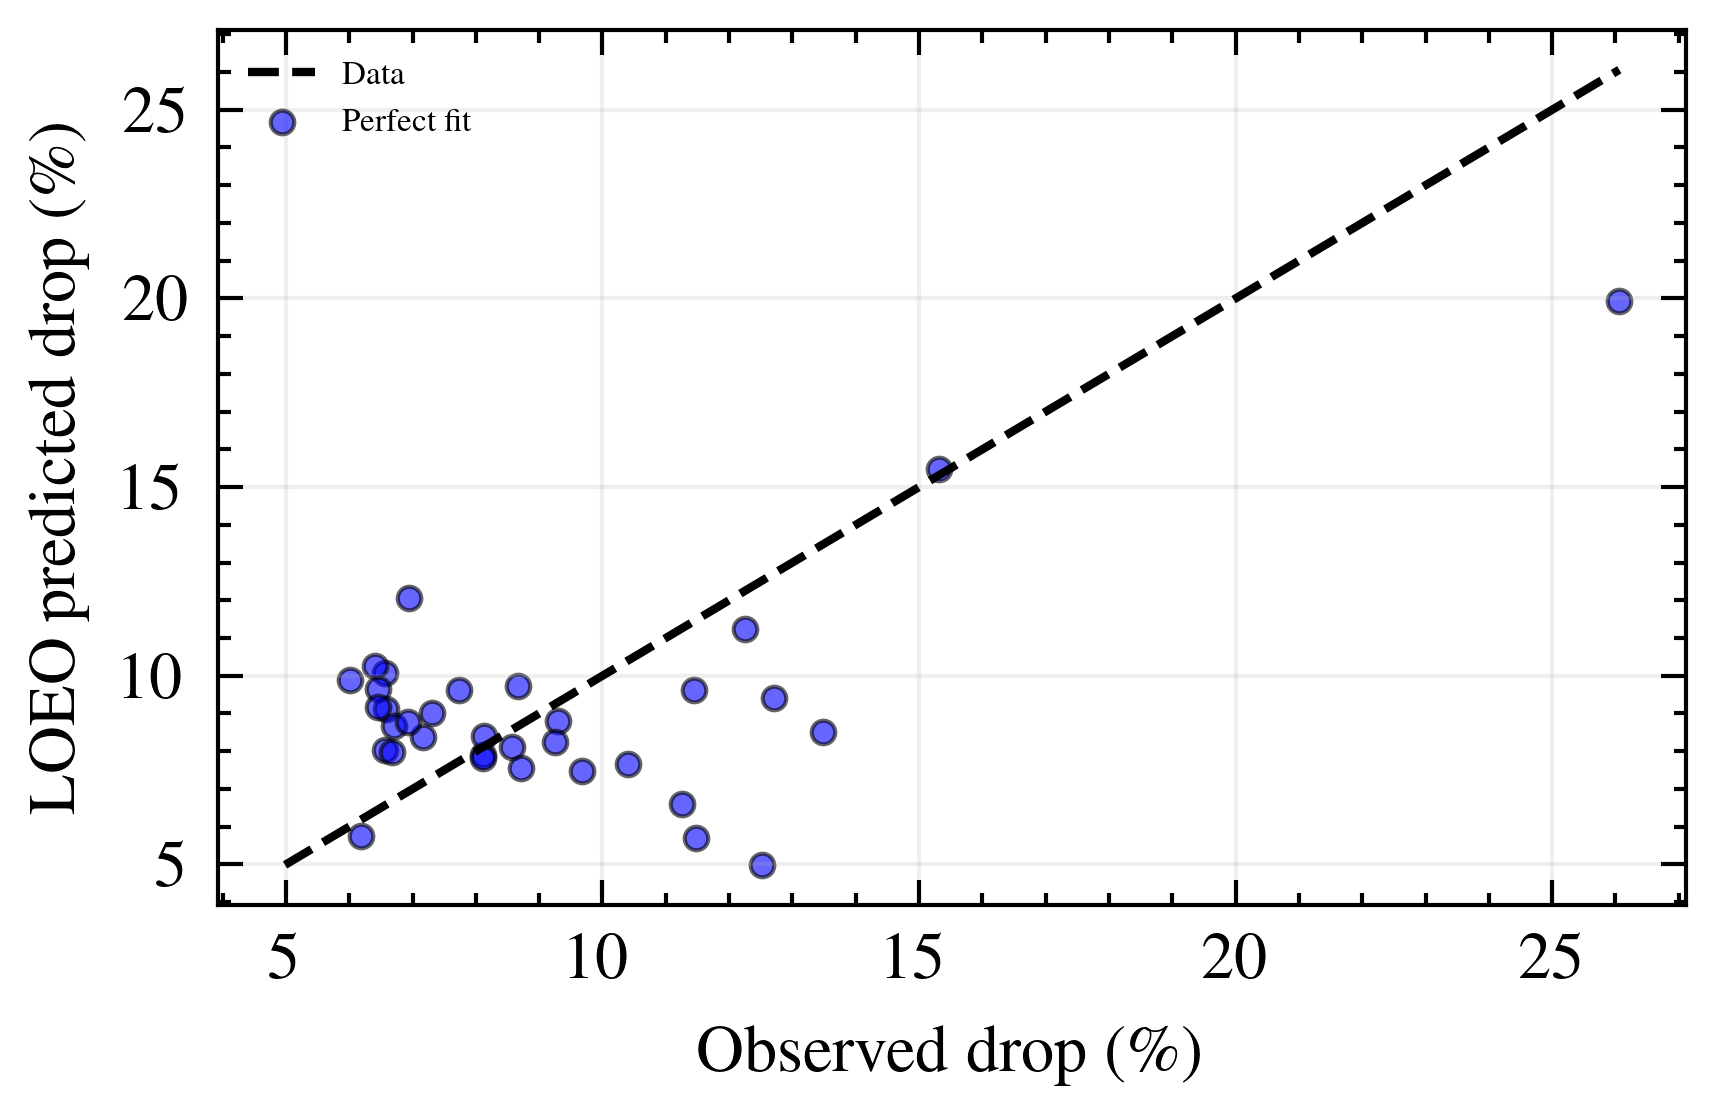

Saved: fig_PLS_drop_pred_vs_obs.png


In [ ]:
ytrue = outr["ytrue"]
yhat = outr["yhat"]

plt.figure(figsize=(3, 2))

mn = min(ytrue.min(), yhat.min())
mx = max(ytrue.max(), yhat.max())
plt.plot([mn, mx], [mn, mx], linestyle="--", label="Data")
plt.grid(alpha=0.2)
plt.scatter(
    ytrue,
    yhat,
    s=8,
    c="b",
    edgecolor="k",
    facecolor="k",
    linewidth=0.5,
    alpha=0.6,
    label="Perfect fit",
)
plt.legend(ncol=1, fontsize=4, loc=2)
plt.xlabel(r"Observed drop (\%)")
plt.ylabel(r"LOEO predicted drop (\%)")
# plt.title(f"PLS (5 comps) LOEO: predicted vs observed\n{fname_r} | tr={tr_r}, norm={nm_r}, adj={adj_r}", fontsize=6)
plt.tight_layout()

fig2_path = DATA_DIR / "fig_PLS_drop_pred_vs_obs.png"
plt.savefig(fig2_path, dpi=220)
plt.show()

print("Saved:", fig2_path)

## 6) Export tables (optional)

This exports:
- full sweep tables for classification / regression
- best-per-file summaries

Useful for making manuscript tables directly.


In [16]:
out_dir = DATA_DIR / "results_tables"
out_dir.mkdir(exist_ok=True)

df_cls.to_csv(out_dir / "sweep_classification_LDA_G3G4G5.csv", index=False)
df_bin.to_csv(out_dir / "sweep_binary_LDA_geG4_vs_G3.csv", index=False)
df_reg.to_csv(out_dir / "sweep_regression_PLS5_drop.csv", index=False)

best_cls.to_csv(out_dir / "best_per_file_classification.csv", index=False)
best_bin.to_csv(out_dir / "best_per_file_binary.csv", index=False)
best_reg.to_csv(out_dir / "best_per_file_regression.csv", index=False)

print("Exported to:", out_dir)

Exported to: results_tables


## 7) Notes for the paper

**Recommended reporting**
- Main: multi-class **G3/G4/G5** (since G2 is extremely rare in the provided labels)
- Secondary: binary `>=G4 vs G3` (operationally meaningful and often stronger)
- Drop regression: **PLS-5** with LOEO, report **R²/MAE/RMSE** and baseline comparison

**Low-effort improvements that often boost performance**
If you can add per-event meta-features (2–4 columns), they usually help:
- `n_nodes` (retained stations after threshold)
- MST total weight or mean edge weight
- graph density (if not fixed)
- percent missing before imputation


In [17]:
from pathlib import Path

import pandas as pd

DATA_DIR = Path("./")

# Features
GRAPH_COLS = [
    "global_efficiency",
    "estrada_index",
    "entropy",
    "fractal",
    "hurst_rs",
    "modularity",
    "assortativity",
    "avg_katz",
    "avg_closeness",
    "avg_betweenness",
    "avg_laplacian",
]

# ===== Best MULTI-CLASS / BINARY (LDA) =====
f_cls = "dataset_all.original_imput-True_threshold-True.csv"
tr_cls, nm_cls, adj_cls = "log", "none", "minkowski"

df_cls = pd.read_csv(DATA_DIR / f_cls)
sub_best = df_cls[
    (df_cls["transformation"] == tr_cls)
    & (df_cls["normalization"] == nm_cls)
    & (df_cls["adjacency_method"] == adj_cls)
].copy()

# (opcional) limitar a clases de interés
sub_best = sub_best[sub_best["intensity"].isin(["G3", "G4", "G5"])].copy()

print("sub_best shape:", sub_best.shape)
print(sub_best[["event_date", "intensity", "drop"]].head())

# ===== Best REGRESSION (PLS) =====
f_reg = "dataset_all_imput-False_threshold-False.csv"
tr_reg, nm_reg, adj_reg = "none", "none", "minkowski"

df_reg = pd.read_csv(DATA_DIR / f_reg)
sub_best_reg = df_reg[
    (df_reg["transformation"] == tr_reg)
    & (df_reg["normalization"] == nm_reg)
    & (df_reg["adjacency_method"] == adj_reg)
].copy()

print("sub_best_reg shape:", sub_best_reg.shape)
print(sub_best_reg[["event_date", "drop", "intensity"]].head())

sub_best shape: (33, 18)
     event_date intensity   drop
19   2024-05-10        G5  15.32
49   2024-03-24        G4  11.47
109  2002-04-17        G3   6.56
139  2003-10-29        G5  26.06
169  2003-11-20        G5   6.58
sub_best_reg shape: (34, 18)
     event_date   drop intensity
9    2024-05-10  15.32        G5
39   2024-03-24  11.47        G4
69   2023-04-23   6.57        G2
99   2002-04-17   6.56        G3
129  2003-10-29  26.06        G5


In [18]:
import numpy as np
import pandas as pd
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler


def lda_importance_loeo(
    df_sub, feature_cols, y_col="intensity", classes=("G3", "G4", "G5")
):
    df_sub = df_sub[df_sub[y_col].isin(classes)].copy()
    X = df_sub[feature_cols].to_numpy()
    y = df_sub[y_col].to_numpy()

    loo = LeaveOneOut()
    imp_list = []
    for tr, te in loo.split(X):
        X_tr, y_tr = X[tr], y[tr]
        X_tr = SimpleImputer(strategy="median").fit_transform(X_tr)
        X_tr = StandardScaler().fit_transform(X_tr)

        lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)

        # importance via |scalings| weighted by explained variance
        S = lda.scalings_
        r = getattr(lda, "explained_variance_ratio_", None)
        if r is None:
            r = np.ones(S.shape[1]) / S.shape[1]
        imp = np.sum(np.abs(S) * r.reshape(1, -1), axis=1)
        imp_list.append(imp)

    imp_arr = np.vstack(imp_list)
    out = (
        pd.DataFrame(
            {
                "feature": feature_cols,
                "importance_mean": imp_arr.mean(axis=0),
                "importance_std": imp_arr.std(axis=0, ddof=1),
            }
        )
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )
    return out


def lda_importance_binary_loeo(
    df_sub, feature_cols, y_col="intensity", pos=("G4", "G5"), neg="G3"
):
    df_sub = df_sub[df_sub[y_col].isin(set(pos) | {neg})].copy()
    X = df_sub[feature_cols].to_numpy()
    y = np.array([1 if v in pos else 0 for v in df_sub[y_col].to_numpy()])

    loo = LeaveOneOut()
    imp_list = []
    for tr, te in loo.split(X):
        X_tr, y_tr = X[tr], y[tr]
        X_tr = SimpleImputer(strategy="median").fit_transform(X_tr)
        X_tr = StandardScaler().fit_transform(X_tr)

        lda = LinearDiscriminantAnalysis().fit(X_tr, y_tr)
        imp_list.append(np.abs(lda.coef_[0]))  # standardized space

    imp_arr = np.vstack(imp_list)
    out = (
        pd.DataFrame(
            {
                "feature": feature_cols,
                "importance_mean": imp_arr.mean(axis=0),
                "importance_std": imp_arr.std(axis=0, ddof=1),
            }
        )
        .sort_values("importance_mean", ascending=False)
        .reset_index(drop=True)
    )
    return out


def pls_coeffs_loeo(df_sub, feature_cols, y_col="drop", n_components=5):
    X = df_sub[feature_cols].to_numpy()
    y = df_sub[y_col].to_numpy().astype(float)

    loo = LeaveOneOut()
    coef_list = []
    for tr, te in loo.split(X):
        X_tr, y_tr = X[tr], y[tr]

        imp = SimpleImputer(strategy="median")
        X_tr = imp.fit_transform(X_tr)

        sc = StandardScaler()
        X_tr = sc.fit_transform(X_tr)

        pls = PLSRegression(n_components=n_components).fit(X_tr, y_tr)
        coef_list.append(pls.coef_.ravel())  # standardized X space

    C = np.vstack(coef_list)
    out = (
        pd.DataFrame(
            {
                "feature": feature_cols,
                "coef_mean": C.mean(axis=0),
                "abscoef_mean": np.mean(np.abs(C), axis=0),
                "coef_std": C.std(axis=0, ddof=1),
            }
        )
        .sort_values("abscoef_mean", ascending=False)
        .reset_index(drop=True)
    )
    return out

In [19]:
# Ejemplo de uso (usa tu subset "best" ya filtrado por transf/norm/adj):
imp_mc = lda_importance_loeo(sub_best, GRAPH_COLS)
imp_bin = lda_importance_binary_loeo(sub_best, GRAPH_COLS)
imp_pls = pls_coeffs_loeo(sub_best_reg, GRAPH_COLS)
display(imp_mc.head(8))
display(imp_bin.head(8))
display(imp_pls.head(8))

,feature,importance_mean,importance_std
0,avg_katz,7.231606,1.054283
1,estrada_index,4.983156,0.623579
2,avg_laplacian,4.561071,0.566962
3,entropy,4.036409,0.537783
4,modularity,2.761148,0.484999
5,global_efficiency,2.358001,1.012679
6,avg_betweenness,1.157048,0.568848
7,avg_closeness,0.946518,0.721059


,feature,importance_mean,importance_std
0,avg_katz,20.206053,3.637331
1,avg_laplacian,12.230911,1.484803
2,entropy,10.773518,1.362310
3,estrada_index,8.080939,1.047568
4,modularity,6.380352,0.898401
5,global_efficiency,2.006018,3.066570
6,hurst_rs,1.988160,0.277885
7,avg_closeness,1.944699,2.134816


,feature,coef_mean,abscoef_mean,coef_std
0,assortativity,4.414518,4.414518,0.270728
1,avg_betweenness,-4.343255,4.343255,0.248400
2,modularity,-0.650173,0.650173,0.090629
3,fractal,-0.646925,0.646925,0.104459
4,avg_laplacian,-0.574452,0.574452,0.088045
5,avg_katz,-0.571285,0.571285,0.043102
6,global_efficiency,-0.301592,0.301592,0.043452
7,estrada_index,0.214220,0.214220,0.081143
